In [ ]:
import os

# Set Keras backend
os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

# Standard Library imports
import json
import math

# Third-party imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import keras
from keras import losses, ops, optimizers, metrics
from keras.optimizers import schedules
from keras.applications.imagenet_utils import decode_predictions
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

from tensorflow.keras.metrics import Precision, Recall



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/praeciso/tt",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/praeciso/tt",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'
)

# Normalize the dataset
normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 330 files belonging to 4 classes.
Using 264 files for training.
Found 330 files belonging to 4 classes.
Using 66 files for validation.


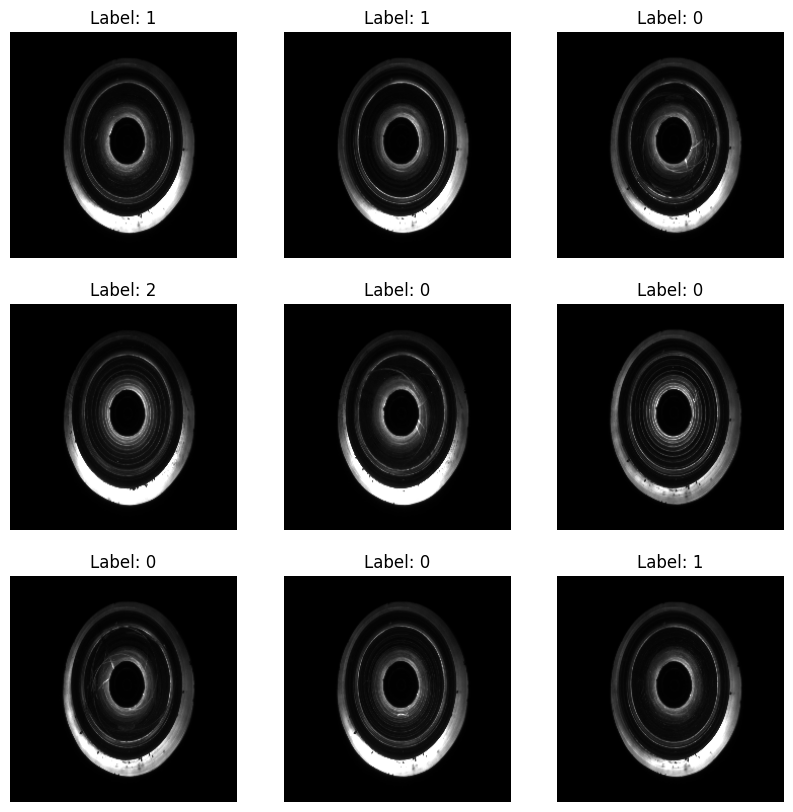

In [ ]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(min(9, images.shape[0])):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.show()

In [ ]:
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError, CategoricalCrossentropy
import matplotlib.pyplot as plt

base_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"]
)

history = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.3924 - loss: 1.3111 - val_accuracy: 0.4545 - val_loss: 1.2942
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 567ms/step - accuracy: 0.3951 - loss: 1.3227 - val_accuracy: 0.4545 - val_loss: 1.2815
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 663ms/step - accuracy: 0.4325 - loss: 1.2365 - val_accuracy: 0.4545 - val_loss: 1.2736
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4736 - loss: 1.2891 - val_accuracy: 0.4545 - val_loss: 1.2685
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 742ms/step - accuracy: 0.4724 - loss: 1.2546 - val_accuracy: 0.4545 - val_loss: 1.2660
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4633 - loss: 1.2760 - val_accuracy: 0.4545 - val_loss: 1.2558
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 751ms/step - accuracy: 0.4650 - loss: 1.2886 - val_accuracy: 0.4545 - val_loss: 1.2500
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 657ms/step - accuracy: 0.4301 - loss: 1.2826 - val_accuracy: 0.4545 - val_loss: 1.24

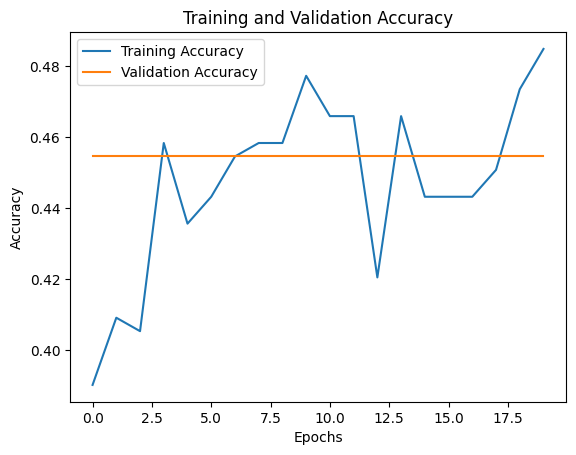

In [ ]:
# Plot metrics
def plot_metrics(history):
    metrics = ["accuracy"]
    for metric in metrics:
        plt.figure()
        plt.plot(history.history[metric], label=f'Training {metric.capitalize()}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric.capitalize()}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.title(f'Training and Validation {metric.capitalize()}')
        plt.show()

plot_metrics(history)

In [ ]:
for layer in base_model.layers[:-20]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"]
)

# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss', patience=3, restore_best_weights=True
# )

fine_tune_epochs = 30
total_epochs = 20 + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=20,
    validation_data=val_ds,
    # callbacks=[early_stopping]
)

# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

Epoch 21/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 66s 5s/step - accuracy: 0.7051 - loss: 0.7627 - val_accuracy: 0.4545 - val_loss: 1.1817
Epoch 22/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 241ms/step - accuracy: 0.7074 - loss: 0.7369 - val_accuracy: 0.4545 - val_loss: 1.1815
Epoch 23/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7526 - loss: 0.6209 - val_accuracy: 0.4545 - val_loss: 1.1831
Epoch 24/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8067 - loss: 0.5239 - val_accuracy: 0.4545 - val_loss: 1.1860
Epoch 25/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8162 - loss: 0.5272 - val_accuracy: 0.4545 - val_loss: 1.1941
Epoch 26/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 661ms/step - accuracy: 0.7800 - loss: 0.5765 - val_accuracy: 0.4545 - val_loss: 1.2009
Epoch 27/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 827ms/step - accuracy: 0.7805 - loss: 0.5089 - val_accuracy: 0.4545 - val_loss: 1.2008
Epoch 28/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 663ms/step - accuracy: 0.7960 - loss: 0.4682 - val_accuracy: 0.4545 - val_loss

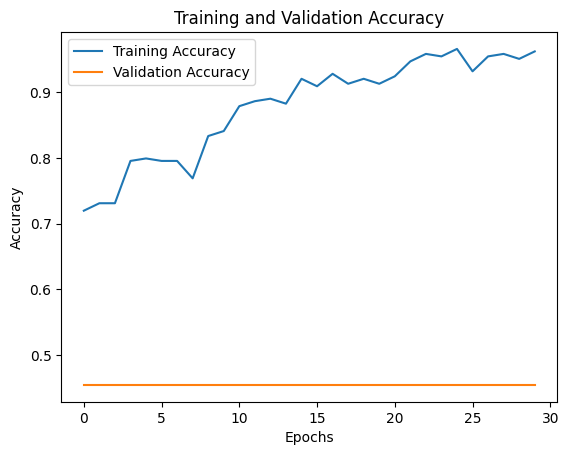

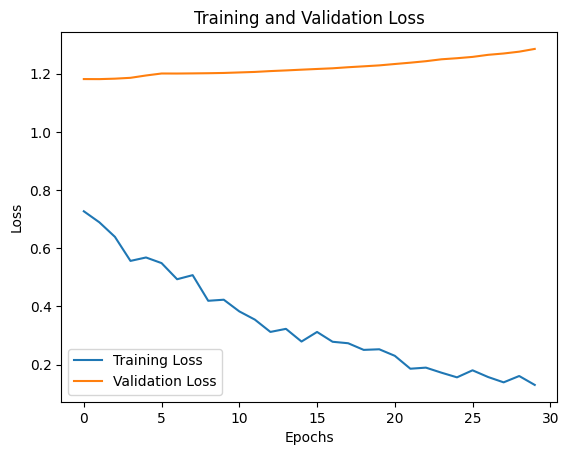

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure()
plt.plot(history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure()
plt.plot(history_fine.history['loss'], label='Training Loss')
plt.plot(history_fine.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Found 61 files belonging to 4 classes.
Class names: ['KO', 'OK', 'RzKO', 'RzOK']
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.2686 - loss: 4.1986

Test Loss: 4.289999485015869
Test Accuracy: 0.26229509711265564
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


<Figure size 800x800 with 0 Axes>

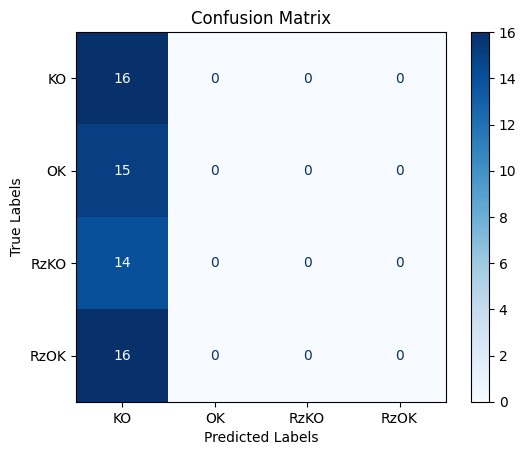


Classification Report:
              precision    recall  f1-score   support

          KO       0.26      1.00      0.42        16
          OK       0.00      0.00      0.00        15
        RzKO       0.00      0.00      0.00        14
        RzOK       0.00      0.00      0.00        16

    accuracy                           0.26        61
   macro avg       0.07      0.25      0.10        61
weighted avg       0.07      0.26      0.11        61



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


<Figure size 1000x800 with 0 Axes>

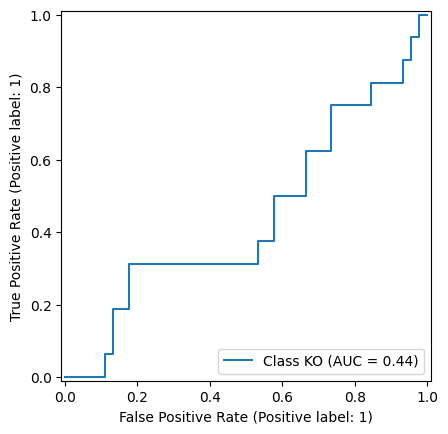

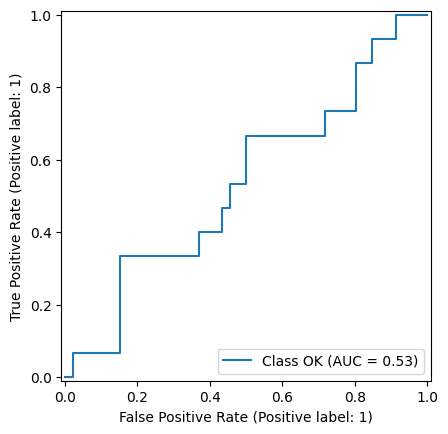

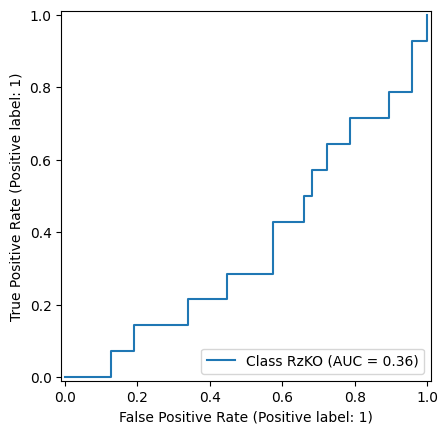

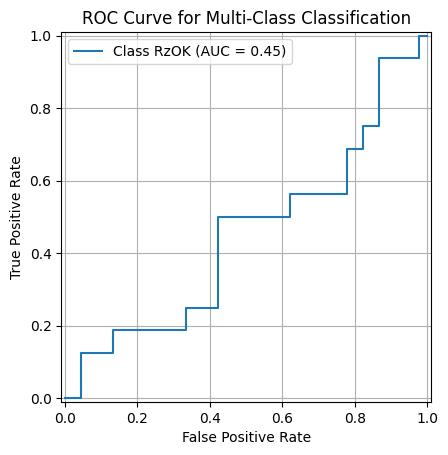

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import label_binarize
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/praeciso/ttt",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

class_names = test_dataset.class_names
print("Class names:", class_names)

test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"\nTest Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

y_pred = []
y_true = []

for images, labels in test_dataset:
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)

plt.figure(figsize=(8, 8))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

y_true_binarized = label_binarize(y_true, classes=range(len(class_names)))
y_pred_probabilities = []

for images, _ in test_dataset:
    predictions = model.predict(images)
    y_pred_probabilities.extend(predictions)

y_pred_probabilities = np.array(y_pred_probabilities)

plt.figure(figsize=(10, 8))
for i, class_name in enumerate(class_names):
    RocCurveDisplay.from_predictions(
        y_true_binarized[:, i], y_pred_probabilities[:, i], name=f"Class {class_name}"
    )
plt.title("ROC Curve for Multi-Class Classification")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.grid()
plt.show()
